In [6]:
import gzip
import multiprocessing as mp
import shutil
import time
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import seaborn as sns
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask.distributed import performance_report

from confscale.parser import read_smi_to_dask
from confscale.parser import smi2parquet
from confscale.parser import write_dask_to_parquet
from confscale.utils import compute_dataset_size

In [3]:
dataset_path = "../data/raw/ZINC20_drug_like"

In [4]:
# Find all .smi files in the dataset_path directory and its subdirectories
smi_files = list(Path(dataset_path).glob("**/*.smi"))

# Calculate the size of each file
file_sizes = [(file, file.stat().st_size) for file in smi_files]

# Create a dataframe to store the results
file_size_df = pd.DataFrame(file_sizes, columns=["file_path", "size_bytes"])

# Add columns for size in KB, MB
file_size_df["size_kb"] = file_size_df["size_bytes"] / 1024
file_size_df["size_mb"] = file_size_df["size_kb"] / 1024

# Calculate total size
total_size_bytes = file_size_df["size_bytes"].sum()
total_size_mb = total_size_bytes / (1024 * 1024)
total_size_gb = total_size_mb / 1024

print(f"Found {len(smi_files)} .smi files")
print(f"Total size: {total_size_bytes:,} bytes ({total_size_mb:.2f} MB, {total_size_gb:.2f} GB)")

# Display the first few files with their sizes
print("\nSample of files and their sizes:")
display(file_size_df.head())

# Optional: summary statistics of file sizes
print("\nFile size statistics (in MB):")
display(file_size_df["size_mb"].describe())

Found 90 .smi files
Total size: 47,406,986,871 bytes (45210.83 MB, 44.15 GB)

Sample of files and their sizes:


,file_path,size_bytes,size_kb,size_mb
0,../data/raw/ZINC20_drug_like/FB/FBAD.smi,217834453,2.127290e+05,207.743123
1,../data/raw/ZINC20_drug_like/GI/GIAD.smi,566982131,5.536935e+05,540.716296
2,../data/raw/ZINC20_drug_like/CG/CGAD.smi,328958656,3.212487e+05,313.719421
3,../data/raw/ZINC20_drug_like/BD/BDAD.smi,158482626,1.547682e+05,151.140810
4,../data/raw/ZINC20_drug_like/FF/FFAD.smi,1088222358,1.062717e+06,1037.809713



File size statistics (in MB):


count      90.000000
mean      502.342509
std       522.726208
min         0.419286
25%       107.876073
50%       451.343108
75%       652.821224
max      3352.185327
Name: size_mb, dtype: float64

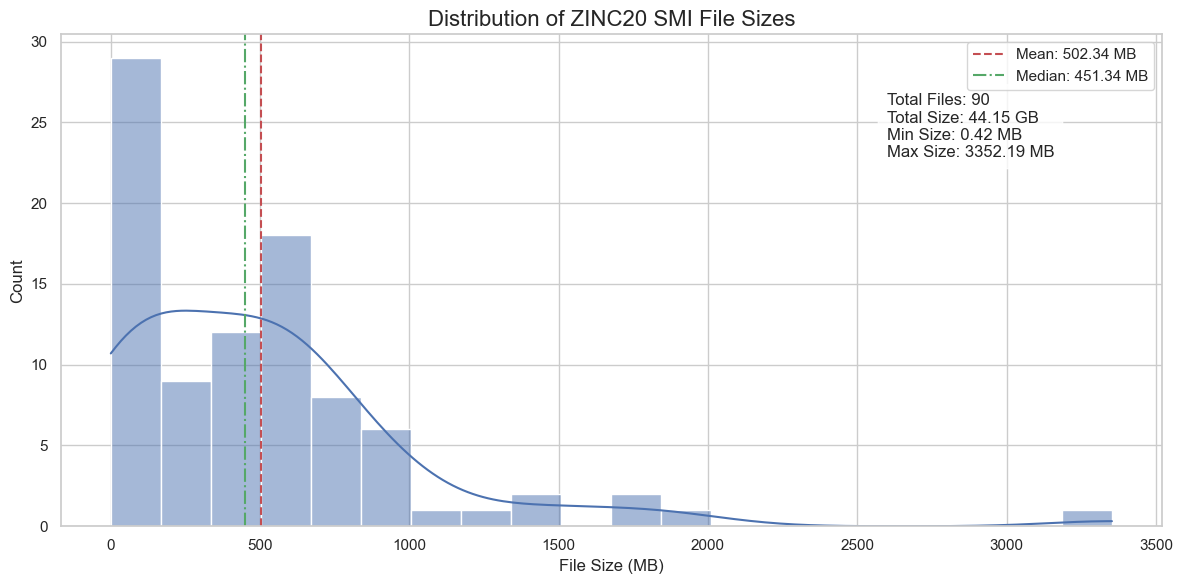

In [ ]:
# Set up the plot style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create a histogram of file sizes in MB
ax = sns.histplot(file_size_df["size_mb"], bins=20, kde=True)
ax.set_title("Distribution of ZINC20 SMI File Sizes", fontsize=16)
ax.set_xlabel("File Size (MB)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Add vertical line for mean and median
mean_size = file_size_df["size_mb"].mean()
median_size = file_size_df["size_mb"].median()
plt.axvline(mean_size, color="r", linestyle="--", label=f"Mean: {mean_size:.2f} MB")
plt.axvline(median_size, color="g", linestyle="-.", label=f"Median: {median_size:.2f} MB")

# Add legend
plt.legend()

# Show some statistics as text
stats_text = (
    f"Total Files: {len(file_size_df)}\n"
    f"Total Size: {total_size_gb:.2f} GB\n"
    f"Min Size: {file_size_df['size_mb'].min():.2f} MB\n"
    f"Max Size: {file_size_df['size_mb'].max():.2f} MB"
)
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords="axes fraction", bbox={"boxstyle": "round,pad=0.5", "fc": "white", "alpha": 0.8})

plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_parquet("../data/processed/zinc20_drug_like.parquet")

In [ ]:
schema = pa.schema(
    [
        pa.field("smiles", pa.string()),
        pa.field("zinc_id", pa.uint32()),
        pa.field("tranches", pa.string()),
    ],
    metadata={
        "description": "ZINC20 subset",
        "Predefined_Subsets": "Drug-Like",
        "Highest_Reactivity": "Anodyne",
        "Highest_Activity_exclusive": "True",
        "Minimum_Purchasability": "Wait_Ok",
        "Minimum_Purchasability_exclusive": "True",
        "source": "https://zinc20.docking.org/",
        "smiles": "Simplified Molecular Input Line Entry System ( SMILES ) notation",
        "zinc_id": "Unique identifier for each molecule in the ZINC database",
        "tranches": "Data partitioning information based on logP and molecular weight",
    },
)

In [11]:
data = smi2parquet(dataset_path=dataset_path, schema=schema, partitioning=ds.partitioning(pa.schema([("tranches", pa.string())])))

In [12]:
final_output_path = "../data/processed/ZINC20_drug_like"
minrowpergroup = 10**6
maxrowpergroup = 2 * 10**6
maxrowperfile = 100 * 10**6

In [6]:
pa.set_io_thread_count(16)

In [7]:
def write_dataset_to_parquet(
    dataset: ds.Dataset,
    output_path: str,
    min_rows_per_group: int = 10**5,
    max_rows_per_group: int = 1024 * 1024,
    max_rows_per_file: int = 100 * 10**6,
    compression: str = "zstd",
    compression_level: int = 3,
) -> None:
    """
    Writes a PyArrow dataset to Parquet format with specified parameters.

    Args:
        dataset (ds.Dataset): The PyArrow dataset to write.
        output_path (str): Path where the Parquet dataset will be written.
        min_rows_per_group (int): Minimum number of rows per row group.
        max_rows_per_group (int): Maximum number of rows per row group.
        max_rows_per_file (int): Maximum number of rows per file.
        compression (str): Compression algorithm to use.
        compression_level (int): Compression level.
    """
    ds.write_dataset(
        dataset,
        output_path,
        format="parquet",
        min_rows_per_group=min_rows_per_group,
        max_rows_per_group=max_rows_per_group,
        max_rows_per_file=max_rows_per_file,
        file_options=ds.ParquetFileFormat().make_write_options(compression=compression, compression_level=compression_level),
    )

In [8]:
1024 * 1024

1048576

In [9]:
def benchmark_compression(
    dataset: ds.Dataset,
    output_path: str,
    compression: str,
    compression_level: int | None = None,
):
    """
    Benchmarks different compression algorithms for Parquet writing.

    Args:
        input_path (str): Path to the input SMI files.
        output_path (str): Path to the output Parquet files.
        compression (str): Compression algorithm to use (e.g., "snappy", "gzip", "brotli", "zstd", "lz4").
        compression_level (int, optional): Compression level for algorithms that support it. Defaults to None.
        blocksize (str): Block size for reading the SMI files.
        sep (str): Separator used in the SMI files.
    """

    result_dict = {
        "compression": compression,
        "compression_level": compression_level,
        "duration": None,
        "input_size": compute_dataset_size(dataset),
        "output_size": None,
        "compression_ratio": None,
    }

    start_time = time.time()

    # Write the dataset to Parquet format with the specified compression
    write_dataset_to_parquet(
        dataset,
        output_path,
        min_rows_per_group=10**5,
        max_rows_per_group=1024 * 1024,
        max_rows_per_file=100 * 10**6,
        compression=compression,
        compression_level=compression_level,
    )

    result_dict["duration"] = time.time() - start_time

    # get size info

    result_dict["output_size"] = compute_dataset_size(ds.dataset(output_path, format="parquet"))
    result_dict["compression_ratio"] = result_dict["input_size"] / result_dict["output_size"]

    # clean up output directory
    if Path(output_path).exists():
        shutil.rmtree(output_path)

    return result_dict

In [10]:
compression_infos = [
    # {
    #     "compression" : "snappy",
    #     "compression_level" : None,
    # },
    # {
    #     "compression": "gzip",
    #     "compression_level": range(1, 10),
    # },
    # {
    #     "compression": "brotli",
    #     "compression_level": range(12),
    # },
    {
        "compression": "zstd",
        "compression_level": range(1, 23),
    },
    {
        "compression": "lz4",
        "compression_level": range(1, 13),
    },
]
# Initialize list to store benchmark results
bench_mark_results = []

# For each compression algorithm and level combination
for info in compression_infos:
    compression_algorithm = info["compression"]
    compression_levels = info["compression_level"]
    algorithm_results = []

    # Create directory for this compression algorithm
    output_dir = Path("../reports/ZINC20_compression")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Test with different compression levels if specified
    if compression_levels is None:
        result = benchmark_compression(
            dataset=data,
            output_path=f"../data/processed/ZINC20_{compression_algorithm}_test",
            compression=compression_algorithm,
            compression_level=None,
        )
        algorithm_results.append(result)
        bench_mark_results.append(result)
    else:
        # For each compression level in the range
        for level in compression_levels:
            result = benchmark_compression(
                dataset=data,
                output_path=f"../data/processed/ZINC20_{compression_algorithm}_{level}_test",
                compression=compression_algorithm,
                compression_level=level,
            )
            algorithm_results.append(result)
            bench_mark_results.append(result)

    # Save results for this compression algorithm immediately
    algorithm_df = pd.DataFrame(algorithm_results)
    algorithm_df.to_csv(output_dir / f"benchmark_results_parquet_pyarrow_{compression_algorithm}.csv", index=False)

In [11]:
compression_infos = [
    # {
    #     "compression" : "snappy",
    #     "compression_level" : None,
    # },
    # {
    #     "compression": "gzip",
    #     "compression_level": range(1, 10),
    # },
    {
        "compression": "brotli",
        "compression_level": range(12),
    },
    # {
    #     "compression": "zstd",
    #     "compression_level": range(1, 23),
    # },
    # {
    #     "compression": "lz4",
    #     "compression_level": range(1, 13),
    # },
]
# Initialize list to store benchmark results
bench_mark_results = []

# For each compression algorithm and level combination
for info in compression_infos:
    compression_algorithm = info["compression"]
    compression_levels = info["compression_level"]
    algorithm_results = []

    # Create directory for this compression algorithm
    output_dir = Path("../reports/ZINC20_compression")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Test with different compression levels if specified
    if compression_levels is None:
        result = benchmark_compression(
            dataset=data,
            output_path=f"../data/processed/ZINC20_{compression_algorithm}_test",
            compression=compression_algorithm,
            compression_level=None,
        )
        algorithm_results.append(result)
        bench_mark_results.append(result)
    else:
        # For each compression level in the range
        for level in compression_levels:
            result = benchmark_compression(
                dataset=data,
                output_path=f"../data/processed/ZINC20_{compression_algorithm}_{level}_test",
                compression=compression_algorithm,
                compression_level=level,
            )
            algorithm_results.append(result)
            bench_mark_results.append(result)

    # Save results for this compression algorithm immediately
    algorithm_df = pd.DataFrame(algorithm_results)
    algorithm_df.to_csv(output_dir / f"benchmark_results_parquet_pyarrow_{compression_algorithm}.csv", index=False)

In [13]:
cluster = LocalCluster(n_workers=18, memory_limit="1.5GB")
client = Client(cluster)

In [5]:
# client.restart()

In [14]:
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [9]:
def benchmark_compression(
    input_path: str,
    output_path: str,
    compression_algorithm: str,
    compression_level: int | None = None,
    blocksize: str = "128MB",
    sep: str = " ",
    schema: pa.Schema | None = None,
):
    """
    Benchmarks different compression algorithms for Parquet writing.

    Args:
        input_path (str): Path to the input SMI files.
        output_path (str): Path to the output Parquet files.
        compression (str): Compression algorithm to use (e.g., "snappy", "gzip", "brotli", "zstd", "lz4").
        compression_level (int, optional): Compression level for algorithms that support it. Defaults to None.
        blocksize (str): Block size for reading the SMI files.
        sep (str): Separator used in the SMI files.
    """

    result_dict = {
        "compression_algorithm": compression_algorithm,
        "compression_level": compression_level,
        "blocksize": blocksize,
        "duration": None,
        "input_size": None,
        "output_size": None,
        "compression_ratio": None,
        "report_path": None,
    }

    start_time = time.time()

    input_path = Path(input_path)

    experience_name = "_".join([input_path.stem, compression_algorithm, str(compression_level), str(blocksize), "dask-report.html"])

    report_dir = Path(f"../reports/ZINC20_compression/{compression_algorithm}")
    report_dir.mkdir(parents=True, exist_ok=True)

    report_path = report_dir / experience_name
    result_dict["report_path"] = report_path

    start_time = time.time()
    with performance_report(filename=str(report_path)):
        ddf = read_smi_to_dask(
            str(Path(input_path) / "*/*.smi"),
            blocksize=blocksize,
            sep=sep,
        )
        parquet_writer = write_dask_to_parquet(
            ddf,
            output_path,
            compression=compression_algorithm,
            level_compression=compression_level,
            schema=schema,
        )
        parquet_writer.compute()
    result_dict["duration"] = time.time() - start_time

    # get size info
    input_size = compute_dataset_size(
        smi2parquet(
            dataset_path=input_path,
            schema=schema,
            partitioning=ds.partitioning(pa.schema([("tranches", pa.string())])),
        )
    )
    output_size = compute_dataset_size(ds.dataset(output_path, format="parquet"))
    result_dict["input_size"] = input_size
    result_dict["output_size"] = output_size
    result_dict["compression_ratio"] = input_size / output_size

    # clean up output directory
    if Path(output_path).exists():
        shutil.rmtree(output_path)

    return result_dict

In [1]:
compression_infos = [
    # {
    #     "compression" : "snappy",
    #     "compression_level" : None,
    #     "blocksize" : ["16MB", "32MB", "64MB"],
    # },
    # {
    #     "compression": "gzip",
    #     "compression_level": range(1, 10),
    #     "blocksize": ["16MB", "32MB", "64MB"],
    # },
    # {
    #     "compression": "brotli",
    #     "compression_level": range(12),
    #     "blocksize": ["16MB", "32MB", "64MB"],
    # },
    {
        "compression": "zstd",
        "compression_level": range(1, 23),
        "blocksize": ["16MB", "32MB", "64MB"],
    },
    {
        "compression": "lz4",
        "compression_level": range(1, 13),
        "blocksize": ["16MB", "32MB", "64MB"],
    },
]

for info in compression_infos:
    bench_mark_results = []
    compression_algorithm = info["compression"]
    compression_level = info["compression_level"]
    blocksize = info["blocksize"]

    if isinstance(compression_level, range):
        for level in compression_level:
            for block in blocksize:
                result = benchmark_compression(
                    "../data/raw/ZINC20_drug_like/",
                    "../data/processed/zinc20_drug_like/",
                    compression_algorithm=compression_algorithm,
                    compression_level=level,
                    blocksize=block,
                )
                bench_mark_results.append(result)
            # Convert the benchmark results to a DataFrame
        benchmark_df = pd.DataFrame(bench_mark_results)
        # Save the benchmark results to a CSV file
        benchmark_df.to_csv(
            f"../reports/ZINC20_compression/benchmark_results_dask_{compression_algorithm}.csv",
            index=False,
        )
    else:
        for block in blocksize:
            result = benchmark_compression(
                "../data/raw/ZINC20_drug_like/",
                "../data/processed/zinc20_drug_like/",
                compression_algorithm=compression_algorithm,
                compression_level=compression_level,
                blocksize=block,
            )
            bench_mark_results.append(result)
            # Convert the benchmark results to a DataFrame
        benchmark_df = pd.DataFrame(bench_mark_results)
        # Save the benchmark results to a CSV file
        benchmark_df.to_csv(
            f"../reports/ZINC20_compression/benchmark_results_dask_{compression_algorithm}.csv",
            index=False,
        )

NameError: name 'benchmark_compression' is not defined

In [17]:
sep = " "
input_path = "../data/raw/ZINC20_drug_like/"
blocksize = "64MB"

In [18]:
ddf = read_smi_to_dask(
    str(Path(input_path) / "*/*.smi"),
    blocksize=blocksize,
    sep=sep,
)

In [22]:
parquet_writer = write_dask_to_parquet(
    ddf,
    "../data/processed/zinc20_drug_like_test/",
    compression="snappy",
    level_compression=None,
    schema=None,
)

In [23]:
parquet_writer.compute()

2025-09-10 21:56:08,144 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 0.92 GiB -- Worker memory limit: 1.40 GiB
2025-09-10 21:56:14,417 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 0.98 GiB -- Worker memory limit: 1.40 GiB
2025-09-10 21:56:53,407 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

In [24]:
# Find all .parquet files in the processed dataset path
parquet_path = "../data/processed/zinc20_drug_like_test/"
parquet_files = list(Path(parquet_path).glob("**/*.parquet"))

# Calculate the size of each file
file_sizes = [(file, file.stat().st_size) for file in parquet_files]

# Create a dataframe to store the results
file_size_df = pd.DataFrame(file_sizes, columns=["file_path", "size_bytes"])

# Add columns for size in KB, MB
file_size_df["size_kb"] = file_size_df["size_bytes"] / 1024
file_size_df["size_mb"] = file_size_df["size_kb"] / 1024

# Calculate total size
total_size_bytes = file_size_df["size_bytes"].sum()
total_size_mb = total_size_bytes / (1024 * 1024)
total_size_gb = total_size_mb / 1024

print(f"Found {len(parquet_files)} .parquet files")
print(f"Total size: {total_size_bytes:,} bytes ({total_size_mb:.2f} MB, {total_size_gb:.2f} GB)")

# Display the first few files with their sizes
print("\nSample of files and their sizes:")
display(file_size_df.head())

# Optional: summary statistics of file sizes
print("\nFile size statistics (in MB):")
display(file_size_df["size_mb"].describe())

# Calculate compression ratio compared to original data
if "smi_files" in locals() and len(smi_files) > 0:
    orig_size_bytes = sum(file.stat().st_size for file in smi_files)
    compression_ratio = orig_size_bytes / total_size_bytes if total_size_bytes > 0 else 0
    print(f"\nCompression ratio compared to original SMI files: {compression_ratio:.2f}x")
    print(f"Original size: {orig_size_bytes:,} bytes ({orig_size_bytes / (1024 * 1024 * 1024):.2f} GB)")
    print(f"Compressed size: {total_size_bytes:,} bytes ({total_size_gb:.2f} GB)")

Found 719 .parquet files
Total size: 25,636,033,179 bytes (24448.43 MB, 23.88 GB)

Sample of files and their sizes:


,file_path,size_bytes,size_kb,size_mb
0,../data/processed/zinc20_drug_like_test/part.2...,35369380,34540.410156,33.730869
1,../data/processed/zinc20_drug_like_test/part.3...,37116570,36246.650391,35.397120
2,../data/processed/zinc20_drug_like_test/part.1...,37106974,36237.279297,35.387968
3,../data/processed/zinc20_drug_like_test/part.5...,36381226,35528.541016,34.695841
4,../data/processed/zinc20_drug_like_test/part.1...,34520488,33711.414062,32.921303



File size statistics (in MB):


count    719.000000
mean      34.003375
std        4.616062
min        0.277950
25%       33.020966
50%       34.083468
75%       35.558332
max       61.085759
Name: size_mb, dtype: float64


Compression ratio compared to original SMI files: 1.85x
Original size: 47,406,986,871 bytes (44.15 GB)
Compressed size: 25,636,033,179 bytes (23.88 GB)


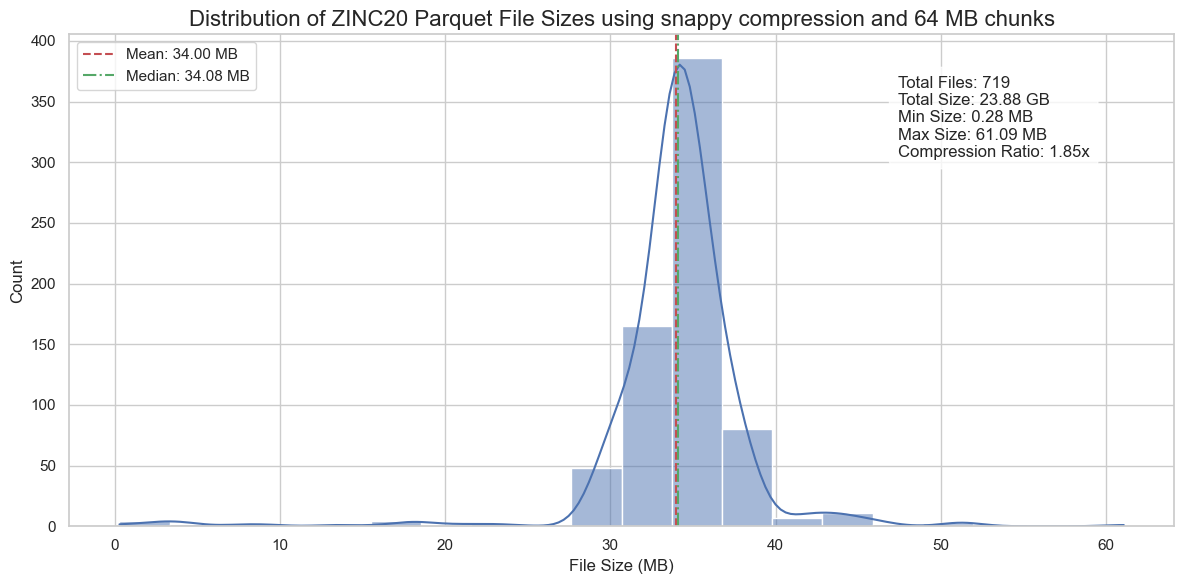

In [ ]:
# Set up the plot style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create a histogram of parquet file sizes in MB
ax = sns.histplot(file_size_df["size_mb"], bins=20, kde=True)
ax.set_title("Distribution of ZINC20 Parquet File Sizes using snappy compression and 64 MB chunks", fontsize=16)
ax.set_xlabel("File Size (MB)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Add vertical line for mean and median
mean_size = file_size_df["size_mb"].mean()
median_size = file_size_df["size_mb"].median()
plt.axvline(mean_size, color="r", linestyle="--", label=f"Mean: {mean_size:.2f} MB")
plt.axvline(median_size, color="g", linestyle="-.", label=f"Median: {median_size:.2f} MB")

# Add legend
plt.legend()

# Show some statistics as text
stats_text = (
    f"Total Files: {len(file_size_df)}\n"
    f"Total Size: {total_size_gb:.2f} GB\n"
    f"Min Size: {file_size_df['size_mb'].min():.2f} MB\n"
    f"Max Size: {file_size_df['size_mb'].max():.2f} MB"
)

# Add compression ratio information
if "compression_ratio" in locals():
    stats_text += f"\nCompression Ratio: {compression_ratio:.2f}x"

plt.annotate(stats_text, xy=(0.75, 0.75), xycoords="axes fraction", bbox={"boxstyle": "round,pad=0.5", "fc": "white", "alpha": 0.8})

plt.tight_layout()
plt.show()

In [27]:
# Find all .parquet files in the processed dataset path
parquet_path = "../data/processed/freedom_space"
parquet_files = list(Path(parquet_path).glob("**/*.parquet"))

# Calculate the size of each file
file_sizes = [(file, file.stat().st_size) for file in parquet_files]

# Create a dataframe to store the results
file_size_df = pd.DataFrame(file_sizes, columns=["file_path", "size_bytes"])

# Add columns for size in KB, MB
file_size_df["size_kb"] = file_size_df["size_bytes"] / 1024
file_size_df["size_mb"] = file_size_df["size_kb"] / 1024

# Calculate total size
total_size_bytes = file_size_df["size_bytes"].sum()
total_size_mb = total_size_bytes / (1024 * 1024)
total_size_gb = total_size_mb / 1024

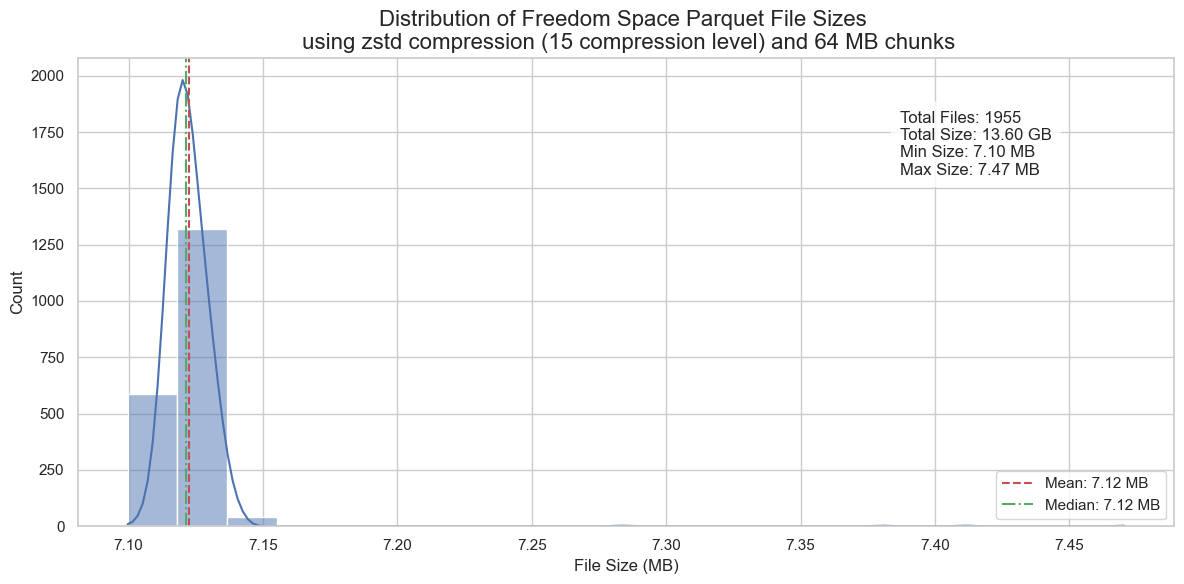

In [ ]:
# Set up the plot style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create a histogram of parquet file sizes in MB
ax = sns.histplot(file_size_df["size_mb"], bins=20, kde=True)
ax.set_title(
    "Distribution of Freedom Space Parquet File Sizes \n using zstd compression (15 compression level) and 64 MB chunks", fontsize=16
)
ax.set_xlabel("File Size (MB)", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Add vertical line for mean and median
mean_size = file_size_df["size_mb"].mean()
median_size = file_size_df["size_mb"].median()
plt.axvline(mean_size, color="r", linestyle="--", label=f"Mean: {mean_size:.2f} MB")
plt.axvline(median_size, color="g", linestyle="-.", label=f"Median: {median_size:.2f} MB")

# Add legend
plt.legend()

# Show some statistics as text
stats_text = (
    f"Total Files: {len(file_size_df)}\n"
    f"Total Size: {total_size_gb:.2f} GB\n"
    f"Min Size: {file_size_df['size_mb'].min():.2f} MB\n"
    f"Max Size: {file_size_df['size_mb'].max():.2f} MB"
)


plt.annotate(stats_text, xy=(0.75, 0.75), xycoords="axes fraction", bbox={"boxstyle": "round,pad=0.5", "fc": "white", "alpha": 0.8})

plt.tight_layout()
plt.show()

In [ ]:
def gzip_compress(file_path: Path | str, output_folder: Path | str, compresslevel: int = 9) -> None:
    """
    Compresses a text file using gzip compression.

    Args:
        file_path (str|Path): Path to the input text file.
        output_folder (str): Path to the output gzip file.
        compresslevel (int): Compression level for gzip (1-9, default is 9).
    """
    file_path = Path(file_path) if isinstance(file_path, str) else file_path
    output_folder = Path(output_folder) if isinstance(output_folder, str) else output_folder

    if not isinstance(file_path, Path):
        raise ValueError("input_file must be a Path or string object")
    if not isinstance(output_folder, Path):
        raise ValueError("output_folder must be a Path or string object")

    output_file_path = Path(output_folder) / (file_path.stem + ".gz")
    with file_path.open("rb") as f_in:
        with gzip.open(output_file_path, "wb", compresslevel=compresslevel) as f_out:
            shutil.copyfileobj(f_in, f_out)


def benchmark_gzip_compression(input_folder: str, output_folder: str, compresslevel: int = 9):
    """
    Benchmarks gzip compression for a given text file.

    Args:
        input_file (str): Path to the input text file.
        output_file (str): Path to the output gzip file.
        compresslevel (int): Compression level for gzip (1-9, default is 9).
    """
    result_dict = {
        "compression": "gzip",
        "compression_level": compresslevel,
        "duration": None,
        "input_size": None,
        "output_size": None,
        "compression_ratio": None,
    }

    start_time = time.time()

    # aggregate all  smi files in the input folder
    input_file_path = Path(input_folder).glob("**/*.smi")

    # create the output folder if it doesn't exist
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    # Compress each file in the input folder
    for file_path in input_file_path:
        gzip_compress(file_path, output_folder, compresslevel=compresslevel)

    result_dict["duration"] = time.time() - start_time
    # get size info
    result_dict["input_size"] = sum([file.stat().st_size for file in Path(input_folder).glob("**/*.smi")])
    result_dict["output_size"] = sum([file.stat().st_size for file in output_folder.glob("*.gz")])
    result_dict["compression_ratio"] = result_dict["input_size"] / result_dict["output_size"]

    # Clean up the output directory
    if output_folder.exists():
        shutil.rmtree(output_folder)

    return result_dict


def benchmark_parralel_gzip_compression(input_folder: str, output_folder: str, compresslevel: int = 9, nb_workers: int = 4):
    """
    Benchmarks gzip compression for a database of smi files in paralel.

    Args:
        input_file (str): Path to the input text file.
        output_file (str): Path to the output gzip file.
        compresslevel (int): Compression level for gzip (1-9, default is 9).
        nb_workers (int): Number of workers to use for parallel processing.
    """
    result_dict = {
        "compression": "gzip",
        "compression_level": compresslevel,
        "duration": None,
        "input_size": None,
        "output_size": None,
        "compression_ratio": None,
    }

    start_time = time.time()

    # aggregate all  smi files in the input folder
    input_file_path = Path(input_folder)
    input_file_path = input_file_path.glob("**/*.smi")

    # create the output folder if it doesn't exist
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    # Create partial function for parallel processing
    partial_gzip_compress = partial(gzip_compress, output_folder=output_folder, compresslevel=compresslevel)

    # Use multiprocessing to compress files in parallel
    with mp.Pool(processes=nb_workers) as pool:
        pool.map(partial_gzip_compress, input_file_path)

    result_dict["duration"] = time.time() - start_time
    result_dict["input_size"] = sum([file.stat().st_size for file in Path(input_folder).glob("**/*.smi")])
    result_dict["output_size"] = sum([file.stat().st_size for file in output_folder.glob("*.gz")])
    result_dict["compression_ratio"] = result_dict["input_size"] / result_dict["output_size"]

    # Clean up the output directory
    if output_folder.exists():
        shutil.rmtree(output_folder)

    return result_dict

In [6]:
list(Path("../data/raw/ZINC20_drug_like/").glob("**/*.smi"))

[PosixPath('../data/raw/ZINC20_drug_like/FB/FBAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/GI/GIAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/CG/CGAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/BD/BDAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/FF/FFAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/HB/HBAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/HH/HHAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/HD/HDAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/EJ/EJAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/CH/CHAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/GC/GCAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/BI/BIAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/EH/EHAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/II/IIAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/EB/EBAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/JE/JEAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/IC/ICAD.smi'),
 PosixPath('../data/raw/ZINC20_drug_like/CA/CAAD

In [8]:
gzip_results = []
compresslevel = range(1, 10)
for level in compresslevel:
    result = benchmark_gzip_compression(
        "../data/raw/ZINC20_drug_like/",
        "../data/processed/zinc20_drug_like/",
        compresslevel=level,
    )
    gzip_results.append(result)

# Convert the benchmark results to a DataFrame
benchmark_df = pd.DataFrame(gzip_results)
# Save the benchmark results to a CSV file
benchmark_df.to_csv(
    "../reports/ZINC20_compression/benchmark_results_text_gzip.csv",
    index=False,
)

In [9]:
# Benchmark parralel gzip compression with various compression levels and worker counts
parralel_gzip_results = []

# Try different compression levels
compresslevel_range = range(1, 10)
worker_counts = [4, 8, 16]  # Different number of workers to test

for level in compresslevel_range:
    for workers in worker_counts:
        # Add a descriptive print to track progress
        # print(f"Benchmarking parallel gzip with level {level} using {workers} workers")

        result = benchmark_parralel_gzip_compression(
            "../data/raw/ZINC20_drug_like/", "../data/processed/zinc20_drug_like_parallel/", compresslevel=level, nb_workers=workers
        )
        # Add number of workers to the result dictionary
        result["nb_workers"] = workers
        parralel_gzip_results.append(result)

# Convert the benchmark results to a DataFrame
parralel_benchmark_df = pd.DataFrame(parralel_gzip_results)

# Save the benchmark results to a CSV file
parralel_benchmark_df.to_csv(
    "../reports/ZINC20_compression/benchmark_results_text_parralel_gzip.csv",
    index=False,
)